In [6]:
# import modules
import tensorflow as tf
from tensorflow import keras

from keras import layers, Sequential, utils
from keras.applications import VGG19

from keras.applications import ResNet50

import numpy as np
import cv2

In [7]:
# import dataset

import pathlib

data_dir = "C:\\Abhishek_Data\\My_Data\\Datasets\\Classification\\PetImages"
data_dir = pathlib.Path(data_dir)

batch_size = 16
img_width = 224
img_height = 224

train_ds = keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2,
    subset="training",
    batch_size=batch_size, 
    image_size=(img_height, img_width),
    seed=123
)

val_ds = keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2,
    subset="validation",
    batch_size=batch_size, 
    image_size=(img_height, img_width),
    seed=123
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)



Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.
['Cat', 'Dog']


Text(0, 0.5, '# Images')

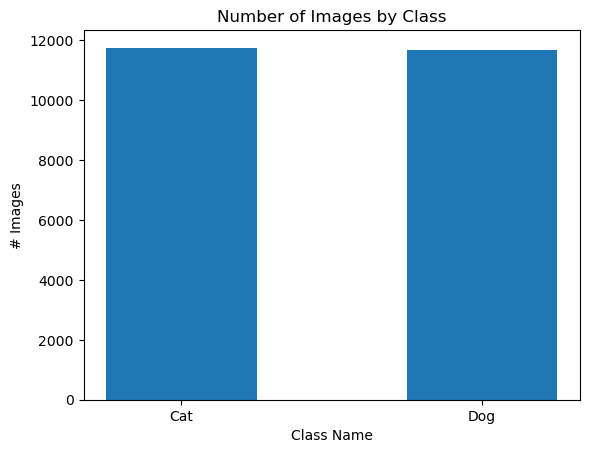

In [8]:
# EDA on image data

import os
from matplotlib import pyplot as plt

# Specify the directory path
directory_path = "C:\\Abhishek_Data\\My_Data\\Datasets\\Classification\\PetImages"
class_dictionary = {}

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(directory_path):
    for folder in dirs:
        img_count_per_class = len(os.listdir(os.path.join(root, folder))) 
        class_dictionary[folder] = img_count_per_class


plt.bar(class_dictionary.keys(), class_dictionary.values(), width = .5)
plt.title("Number of Images by Class")
plt.xlabel('Class Name')
plt.ylabel('# Images')

In [9]:
# data augmentation

data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomCrop(height=img_height, width=img_width)
  ]
)

In [10]:
model = Sequential()
#model.add(data_augmentation)
model.add(VGG19(include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3)))

for layer in model.layers:
    layer.trainable = False

model.add(layers.Flatten())

model.add(layers.Dense(1024))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(2))
model.add(layers.BatchNormalization())
model.add(layers.Activation("softmax"))

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                      

In [11]:
# model training (adding and retraining top classification layers not fine tuning)
import datetime, os

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tensorboard_callback]
)

1172/1172 [==============================] - 508s 420ms/step - loss: 0.1739 - accuracy: 0.9476 - val_loss: 0.0974 - val_accuracy: 0.9667


Confusion Matrix


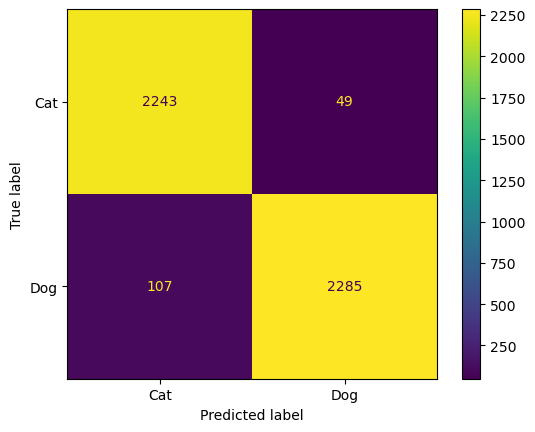

Classification Report
              precision    recall  f1-score   support

         Cat       0.95      0.98      0.97      2292
         Dog       0.98      0.96      0.97      2392

    accuracy                           0.97      4684
   macro avg       0.97      0.97      0.97      4684
weighted avg       0.97      0.97      0.97      4684



In [12]:
# accuracy metrics using model in memory (not saved on disk)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

target_names = val_ds.class_names 

y_true = []
y_pred = []

for images, labels in val_ds:
    y_true = y_true + labels.numpy().tolist() 

    temp_pred = model.predict(images, verbose=0)
    temp_pred = np.argmax(temp_pred, axis = 1)
    y_pred = y_pred + temp_pred.tolist()

print('Confusion Matrix')  
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=val_ds.class_names)
plt.show()


print('Classification Report') 
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
# save as tf SavedModel (pb) -> does not work with 3 MB of file (tflite)
vgg_save_path = "C:\\Abhishek_Data\\My_Data\\VSC_Workspace\\Python\\classification\\trained_models\\saved_model_vgg_tl_with_data_aug_bn_2_dense"
tf.saved_model.save(model, vgg_save_path)

In [ ]:
# accuracy metric calculation : precision, Recall, Confusion Matrix, F1-Score

from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model

modelOnDisk = tf.saved_model.load('C:\\Abhishek_Data\\My_Data\\VSC_Workspace\\Python\\classification\\trained_models\\saved_model_vgg_tl_with_data_aug_bn_2_dense')

target_names = val_ds.class_names

pred_result = modelOnDisk.predict(val_ds)
y_pred = np.argmax(pred_result, axis = 1) 

y_true = []
for image, labels in val_ds:
    y_true = y_true + labels.numpy().tolist()

print('Confusion Matrix')  
print(confusion_matrix(y_true, y_pred))  

print('Classification Report') 
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
https://forums.fast.ai/t/vgg-strength-and-limitations/1218/5

https://towardsdatascience.com/neural-network-architectures-156e5bad51ba   safaf

